# Forward Design Optimization - Workflow

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Conditional Variational Autoencoder (cVAE) in the design of connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

Employ heuristic and stochastic optimization methods, which incorporate the Deep Neural Network as an evaluation tool to identify optimal design parameters. The objective (cost function) minimizes the distance from the Moment-Shear interaction diagram for a given design to a set of pre-defined Moment and Shear load combinations.

**Dependencies**: 
- `DNN.py`
- `Datareader.py`
- `Settings.py`
- `Plot_Functions.py`
- `Saved Models\DNN_Model_Full_V2\DNN_Model_Full_V2.pth`

## Import

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import copy
import os
import pickle

from DataReader import DataReader
from Settings import Directory, Plotting_Parameters
from DNN import DNN
from Plot_Functions import plot_MV_interaction

import warnings
warnings.filterwarnings('ignore')

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [2]:
plot_params = Plotting_Parameters()
directory = Directory()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [18]:
plot_params.params['figure.dpi']=300
plot_params.update()

## Load Data

In [3]:
datareader = DataReader()
df_full = datareader.load('Knee_Connection_Output_red.csv')

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
df_full_filtered.csv
Extended_Database.csv
Extended_Database_filtered_converted.csv
Extended_Database_FilterOn.csv
Extended_Database_test.csv
extended_profiles_filteron_iter_1.csv
extended_profiles_iter_1.csv
extended_profiles_iter_2.csv
extended_profiles_iter_3.csv
GAL_Generated_Data.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
_OLD
Knee_Connection_Output_red.csv: (714385, 53)


## Load Forward Model

In [4]:
model_name = 'DNN_Model_Full_V3'
MODEL_FORWARD_SAVE_FILE = rf"Saved Models\{model_name}\{model_name}.pth"

model_forward = DNN()
model_forward = torch.load(MODEL_FORWARD_SAVE_FILE)

for key, value in model_forward.config.items():
    print(key, value)

features = model_forward.features

batch_size 256
epochs 2500
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Different to V2, do not Cat_h & Cath_stiffc features


## Optimization

### Relevant Functions

First, we need a function to calculate the distance between a given load (Ed) and the interaction curve (Rd). The function should consider the shortest distance from the load to the interaction curve, which is discretized as n $M_{Rd}$ and $V_{Rd}$ coordinates. The distance should therefore be the orthogonal distance between the the closest line segment of the interaction curve and the load. This indicates results in the **error** of the current design.

In [5]:
def calculate_error(curve, points):
    diff = np.diff(curve, axis=0)
    lengths = np.sqrt((diff ** 2).sum(axis=1))
    unit_vectors = diff / lengths[:, np.newaxis]

    points = np.atleast_2d(points)
    start_points = curve[:-1]

    start_to_points = points[:, np.newaxis, :] - start_points
    projections = np.einsum('ijk,jk->ij', start_to_points, unit_vectors)
    projections = np.clip(projections, 0, lengths)

    closest_points = start_points + unit_vectors * projections[..., np.newaxis]
    distances = np.sqrt(((closest_points - points[:, np.newaxis, :]) ** 2).sum(axis=2))
    
    min_distances = distances.min(axis=1)
    closest_indices = distances.argmin(axis=1)

    return min_distances, closest_indices

Loads, which are inside of the interaction curve (Rd), might want to be penalized less, since a design with $R_d > E_d$ could also be accepted. To identify if points are inside or outside of an interaction curve, following functions are implemented:

In [6]:
def check_for_violation(curve, points):
    min_distances, closest_indices = calculate_error(curve, points)
    
    # For each point, get the closest point on the curve
    points = np.atleast_2d(points)
    closest_points_on_curve = get_closest_points_on_curve(curve, points, closest_indices)
    
    # For a convex curve in the first quadrant, we can determine inside/outside by:
    # 1. Creating vectors from origin to the point and to its closest curve point
    origin = np.array([0, 0])
    vectors_to_points = points - origin
    vectors_to_curve = closest_points_on_curve - origin
    
    # 2. Calculate the magnitude of these vectors
    point_magnitudes = np.sqrt((vectors_to_points**2).sum(axis=1))
    curve_magnitudes = np.sqrt((vectors_to_curve**2).sum(axis=1))

    # 3. If the point's magnitude is greater than its projection's magnitude, it's inside
    inside_outside = point_magnitudes > curve_magnitudes
    
    return inside_outside

def get_closest_points_on_curve(curve, points, closest_indices):
    diff = np.diff(curve, axis=0)
    lengths = np.sqrt((diff ** 2).sum(axis=1))
    unit_vectors = diff / lengths[:, np.newaxis]
    
    start_points = curve[:-1]
    
    # For each point, get its corresponding closest segment
    closest_segments = closest_indices
    
    closest_points = np.zeros_like(points)
    
    for i, (point, segment_idx) in enumerate(zip(points, closest_segments)):
        segment_start = start_points[segment_idx]
        unit_vec = unit_vectors[segment_idx]
        
        start_to_point = point - segment_start
        
        # Project this vector onto the segment
        projection = np.dot(start_to_point, unit_vec)
        projection = np.clip(projection, 0, lengths[segment_idx])
        
        # Calculate the closest point on the segment
        closest_point = segment_start + unit_vec * projection
        closest_points[i] = closest_point
        
    return closest_points

### Define Base Profile

Select random sample, which should give the initial values for the parameters, which should be considered fixed in the optimization.

In [7]:
base_profile = df_full.iloc[714381:714382]

Get Interaction curve using the forward model.

In [8]:
n_predictions = 20
M_Rd_pred, V_Rd_pred, targets_predicted = model_forward.get_MV_interaction_prediction(base_profile,n_predictions=n_predictions)
interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T

Define Design Loads based on the initial interaction curve.

In [102]:
M_Ed = np.array([interaction_curve[4][0]*1.05, interaction_curve[10][0]*1.3, interaction_curve[-3][0]*1.1])
V_Ed = np.array([interaction_curve[4][1]*0.9, interaction_curve[10][1]*1.1, interaction_curve[-3][1]*1.1])

design_loads = np.array(list(zip(M_Ed, V_Ed)))

Check if some design loads exceed the resistance capacity.

In [103]:
violations = check_for_violation(interaction_curve, design_loads)

Calculate the error (distance from design loads to interaction curve).

In [104]:
errors, closest_points = calculate_error(
    interaction_curve,
    design_loads
)

In [105]:
def calculate_loss(profile,design_loads,n_predictions=20,penalize_violations=10): 
    M_Rd_pred, V_Rd_pred, _ = model_forward.get_MV_interaction_prediction(profile,n_predictions=n_predictions)

    interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T

    losses, _ = calculate_error(interaction_curve, design_loads)

    violations = check_for_violation(interaction_curve, design_loads)
    losses[violations] *= penalize_violations

    return losses, violations

In [106]:
losses, violations = calculate_loss(base_profile, design_loads)

In [107]:
closest_points_on_curve = get_closest_points_on_curve(
    interaction_curve,
    design_loads,
    closest_points
)

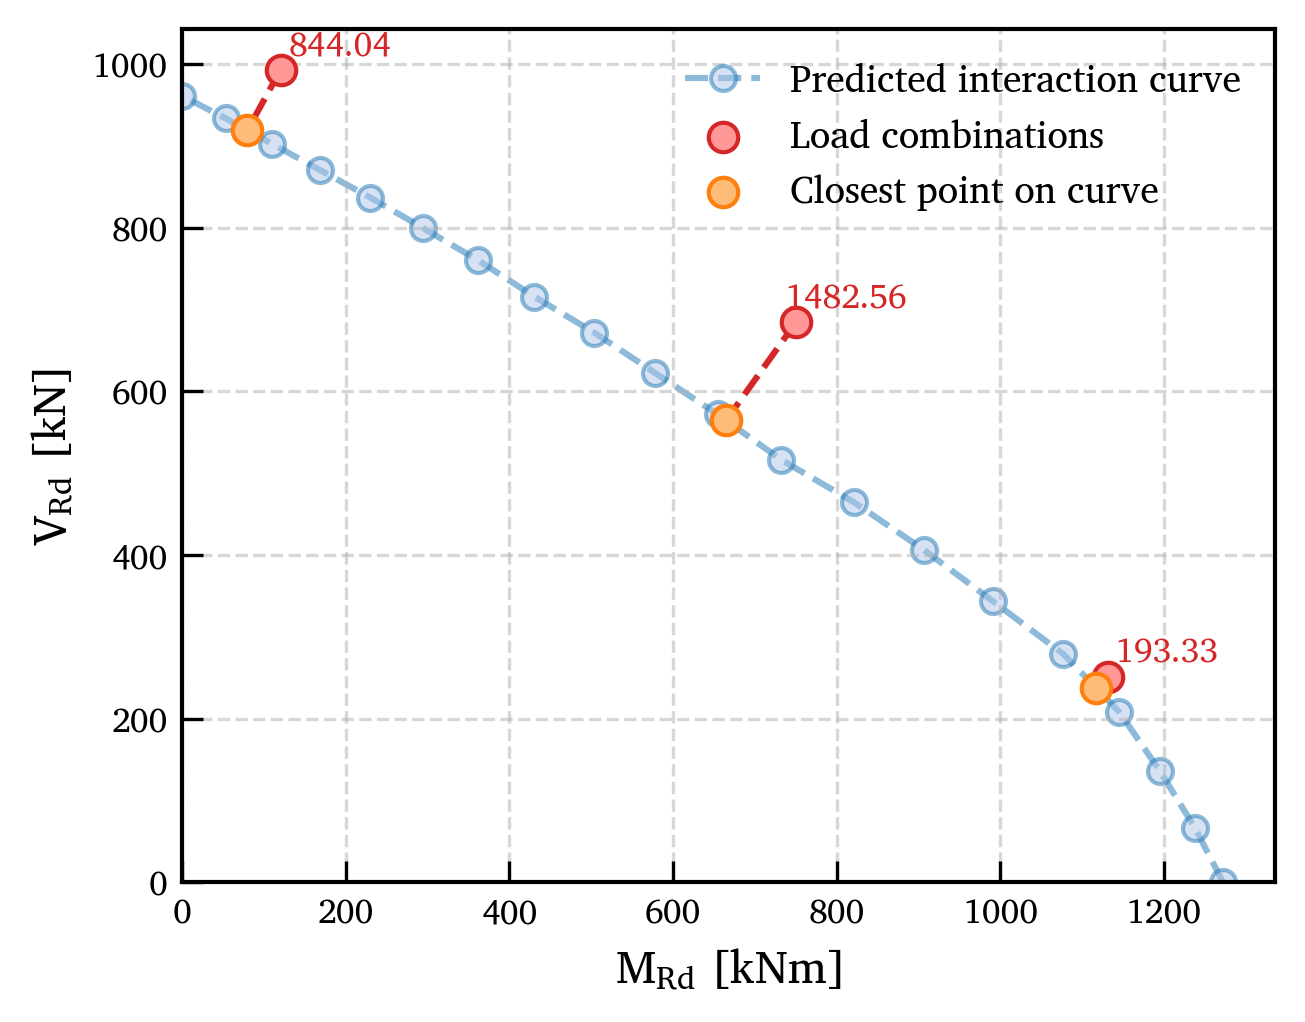

In [108]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75,1.0))

plt.plot(interaction_curve[:, 0],
        interaction_curve[:, 1],
        marker='o',
        markeredgecolor=plot_params.morecolors[0],
        markerfacecolor=plot_params.morecolors[1],
        linestyle='--',                    
        label="Predicted interaction curve",
        alpha=0.5,
        zorder=0)
    
for i, load in enumerate(design_loads):
    colors = [plot_params.morecolors[5],plot_params.morecolors[4]] if not violations[i] else [plot_params.morecolors[7],plot_params.morecolors[6]]
    plt.scatter(load[0],
                load[1],
                s=50,
                facecolors=colors[0],
                edgecolors=colors[1],
                label="Load combinations" if i == 0 else "",
                zorder=3)
    plt.text(load[0]+0.12*np.max(design_loads[0:,]),
             load[1]+0.01*np.max(design_loads[1:,]), 
             f"{losses[i]:.2f}", 
             fontsize=8, ha='right', va='bottom', color=colors[1])
    plt.scatter(closest_points_on_curve[i, 0],
                closest_points_on_curve[i, 1],
                s=50,
                facecolors=plot_params.morecolors[3],
                edgecolors=plot_params.morecolors[2], 
                label='Closest point on curve' if i == 0 else "",
                zorder=3)
    plt.plot([load[0], closest_points_on_curve[i, 0]],
             [load[1], closest_points_on_curve[i, 1]],
             linestyle='--',
             color=plot_params.colors[3],
             zorder=2)

ax.set_aspect('equal', adjustable='box')
plt.legend()
plt.xlim(0,None)
plt.ylim(0,None)
plt.xlabel(rf"{plot_params.feature_labels['M_Rd']}")
plt.ylabel(rf"{plot_params.feature_labels['V_Rd']}")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Define loss function, which should be minimized in optmization. Use `penalize_violations` to adjust how much more loads exceeding the resistance are penalized. If it is set to 1.0, the optimization will just find the best fitting curve to the design loads, no matter if they are exceeding the resistance or not. 

In [109]:
def calculate_loss(profile,design_loads,n_predictions=20,penalize_violations=10): 
    M_Rd_pred, V_Rd_pred, _ = model_forward.get_MV_interaction_prediction(profile,n_predictions=n_predictions)

    interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T

    losses, _ = calculate_error(interaction_curve, design_loads)

    violations = check_for_violation(interaction_curve, design_loads)
    losses[violations] *= penalize_violations

    return losses, violations

$$
\begin{aligned}
& \underset{\text{design variables}}{\text{minimize}} 
& & \sum \alpha_i \, \| \text{design point}_i - \text{resistance}_i \| \\
& \text{where} \quad
& & \alpha_i = 
\begin{cases}
10, & \text{if } \text{design point}_i > \text{resistance}_i \\
1, & \text{otherwise} 
\end{cases} \\
& \text{subject to}
& & g_1(x) \leq \text{upper bound} \\
& 
& & g_2(x) \geq \text{lower bound}
\end{aligned}
$$


Define the design parameters, which can change in the optimization.

In [110]:
design_parameters = ['t_stiffc', 'h_wid', 'b_wid', 'd_wid', 't_fwid', 't_wwid', 'Gamma', 'Offset']

Define the bounds.

In [111]:
bounds = list(zip(df_full[design_parameters].min().values,
          df_full[design_parameters].max().values))

In [112]:
for i,param in enumerate(design_parameters):
    print(f"{param}: {base_profile[param].values[0] / bounds[i][1]}")

t_stiffc: 1.0
h_wid: 0.48000000000000004
b_wid: 0.31999999999999995
d_wid: 1.0
t_fwid: 1.0
t_wwid: 0.6666666666666666
Gamma: 0.0
Offset: 0.37666666666666665


Define initial guess.

In [113]:
initial_guess = base_profile[design_parameters].values.flatten()

### Optimization

By what factor should loads exceeding the interaction curve be penalized more:

In [114]:
penalize_violations = 10

I implement the Powell Optimization Search Algorithm. It is a simple non-gradient based search algorithm.

In [115]:
optimization_history = []

# Callback function to record information at each iteration
def callback(params):
    temp_profile = base_profile.copy()

    for i, param in enumerate(design_parameters):
        temp_profile.at[temp_profile.index[0], param] = params[i]
    
    # Calculate individual losses
    individual_losses, violations = calculate_loss(temp_profile, design_loads, penalize_violations)
    total_loss = np.sum(individual_losses)
    
    iteration_data = {
        'parameters': params.copy(),
        'parameter_dict': {param: params[i] for i, param in enumerate(design_parameters)},
        'total_loss': total_loss,
        'individual_losses': individual_losses.copy() if hasattr(individual_losses, 'copy') else individual_losses,
        'violations': violations
    }

    optimization_history.append(iteration_data)

    print(f"Iteration {len(optimization_history)}: Loss = {total_loss:.6f}")
    
    return False  # Return False to continue optimization

In [116]:
def objective(params):
    temp_profile = base_profile.copy()
    for i, param in enumerate(design_parameters):
        temp_profile.at[temp_profile.index[0], param] = params[i]  
    
    # Get the error of the current profile
    losses,_ = calculate_loss(temp_profile,design_loads,penalize_violations)
    total_loss = np.sum(losses)
    return total_loss

In [117]:
result = minimize(
    objective, 
    x0=initial_guess, 
    bounds=bounds, 
    method='Powell',
    callback=callback,
    options={
        'disp': True,              # Display convergence messages
        'maxiter': 500,            # Increased max iterations for more thorough search
        'maxfev': 10000,           # Maximum function evaluations
        'xtol': 1e-3,              # Relative error in solution acceptable for convergence
        'ftol': 1e-3,              # Relative error in function value acceptable for convergence
        'direc': None,             # Initial set of direction vectors (None = identity matrix)
        'return_all': True,        # Return all iterations (useful for detailed analysis)
        'adaptive': True           # Adapt algorithm direction to function characteristics
    }
)

# Extracting the best parameters
optimized_params = dict(zip(design_parameters, result.x))
best_loss = result.fun

print("Optimized parameters:", optimized_params)
print("Best loss:", best_loss)

Iteration 1: Loss = 147.662018
Iteration 2: Loss = 132.990377
Optimization terminated successfully.
         Current function value: 132.990377
         Iterations: 2
         Function evaluations: 368
Optimized parameters: {'t_stiffc': 4.107881971484309, 'h_wid': 499.89890687691644, 'b_wid': 1074.6275320033692, 'd_wid': 25.591453216631137, 't_fwid': 7.498285928624579, 't_wwid': 12.415934472661865, 'Gamma': 0.5443839653532689, 'Offset': 75.30232010066952}
Best loss: 132.99037693078958


## Solution

### Extract the reslts from the optimization

In [118]:
optimized_profile = base_profile.copy()
optimized_profile[design_parameters] = result.x

In [119]:
M_Rd_pred_optim, V_Rd_pred_optim, _ = model_forward.get_MV_interaction_prediction(optimized_profile,n_predictions=n_predictions)
M_Rd_pred_base, V_Rd_pred_base, _ = model_forward.get_MV_interaction_prediction(base_profile,n_predictions=n_predictions)

interaction_curve_optim = np.array([M_Rd_pred_optim, V_Rd_pred_optim]).T
interaction_curve_base = np.array([M_Rd_pred_base, V_Rd_pred_base]).T

In [120]:
errors_minimized, _ = calculate_error(interaction_curve_optim, design_loads)
violations_minimized = check_for_violation(interaction_curve_optim, design_loads)

violations = check_for_violation(interaction_curve, design_loads)
errors_minimized[violations] *= penalize_violations

### Plot Results

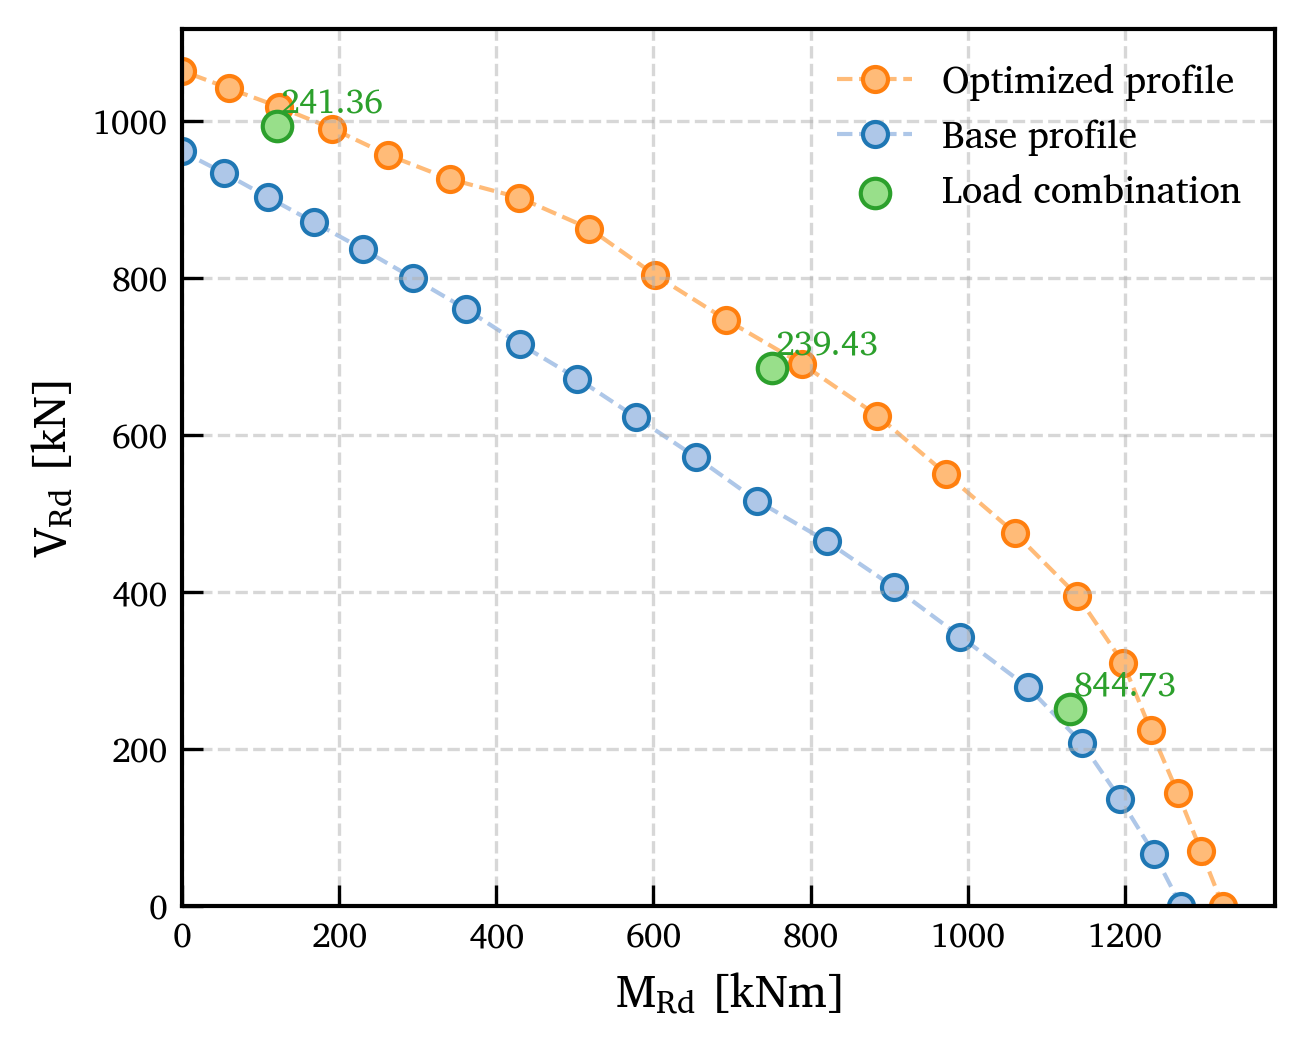

In [122]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75,1.0))

plt.plot(interaction_curve_optim[:, 0],
          interaction_curve_optim[:, 1],
          marker='o',
          color=plot_params.morecolors[3],
          markeredgecolor=plot_params.morecolors[2],
          markerfacecolor=plot_params.morecolors[3],
          linestyle='--',
          linewidth=1,
          zorder=0,
          label="Optimized profile")

plt.plot(interaction_curve_base[:, 0],
          interaction_curve_base[:, 1],
          marker='o',
          color=plot_params.morecolors[1],
          markeredgecolor=plot_params.morecolors[0],
          markerfacecolor=plot_params.morecolors[1],
          linestyle='--',
          linewidth=1,
          zorder=0,
          label="Base profile")

for i, load in enumerate(design_loads):
    colors = [plot_params.morecolors[5],plot_params.morecolors[4]] if not violations_minimized[i] else [plot_params.morecolors[7],plot_params.morecolors[6]]
    plt.scatter(load[0],
                load[1],
                s=50, 
                facecolors=colors[0],
                edgecolors=colors[1],
                label='Load combination' if i == 0 else "",
                zorder=3)
    plt.text(load[0]+0.12*np.max(design_loads[0:,]),
             load[1]+0.01*np.max(design_loads[1:,]), 
             f"{errors_minimized[i]:.2f}", 
             fontsize=8, ha='right', va='bottom', color=colors[1])

plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel(rf"{plot_params.feature_labels['M_Rd']}")
plt.ylabel(rf"{plot_params.feature_labels['V_Rd']}")
ax.set_aspect('equal', adjustable='box')
plt.xlim(0, None)
plt.ylim(0, None)
plt.legend()
plt.show()

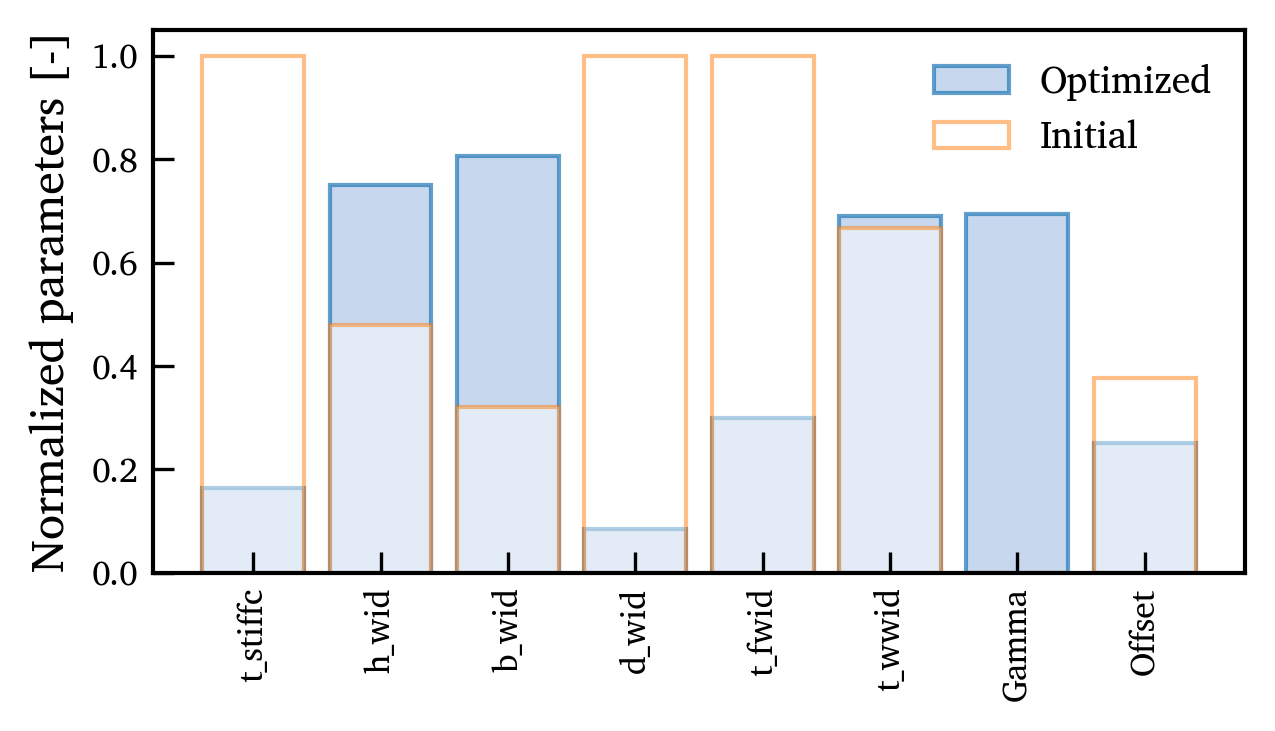

In [157]:


upper_bounds = np.array(bounds)[:,1]
lower_bounds = np.array(bounds)[:,0]

optim_params_values = np.array(list(optimized_params.values()))

params_normed = (optim_params_values - lower_bounds) / (upper_bounds - lower_bounds)

fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75,0.5))

plt.bar(np.arange(len(params_normed)),
        params_normed,
        color=plot_params.morecolors[1],
        edgecolor=plot_params.morecolors[0],
        alpha=0.7,
        label='Optimized',)
params_base_normed = (base_profile[design_parameters].values.flatten() - lower_bounds) / (upper_bounds - lower_bounds)
plt.bar(np.arange(len(params_base_normed)),
        params_base_normed,
        facecolor='white',
        edgecolor=plot_params.morecolors[2],
        alpha=0.5,
        label='Initial',)

plt.legend()

ax.set_xticks(np.arange(len(params_normed)),list(optimized_params.keys()), rotation=90)
plt.ylabel('Normalized parameters [-]')
plt.show()

### Illustrate the interim results

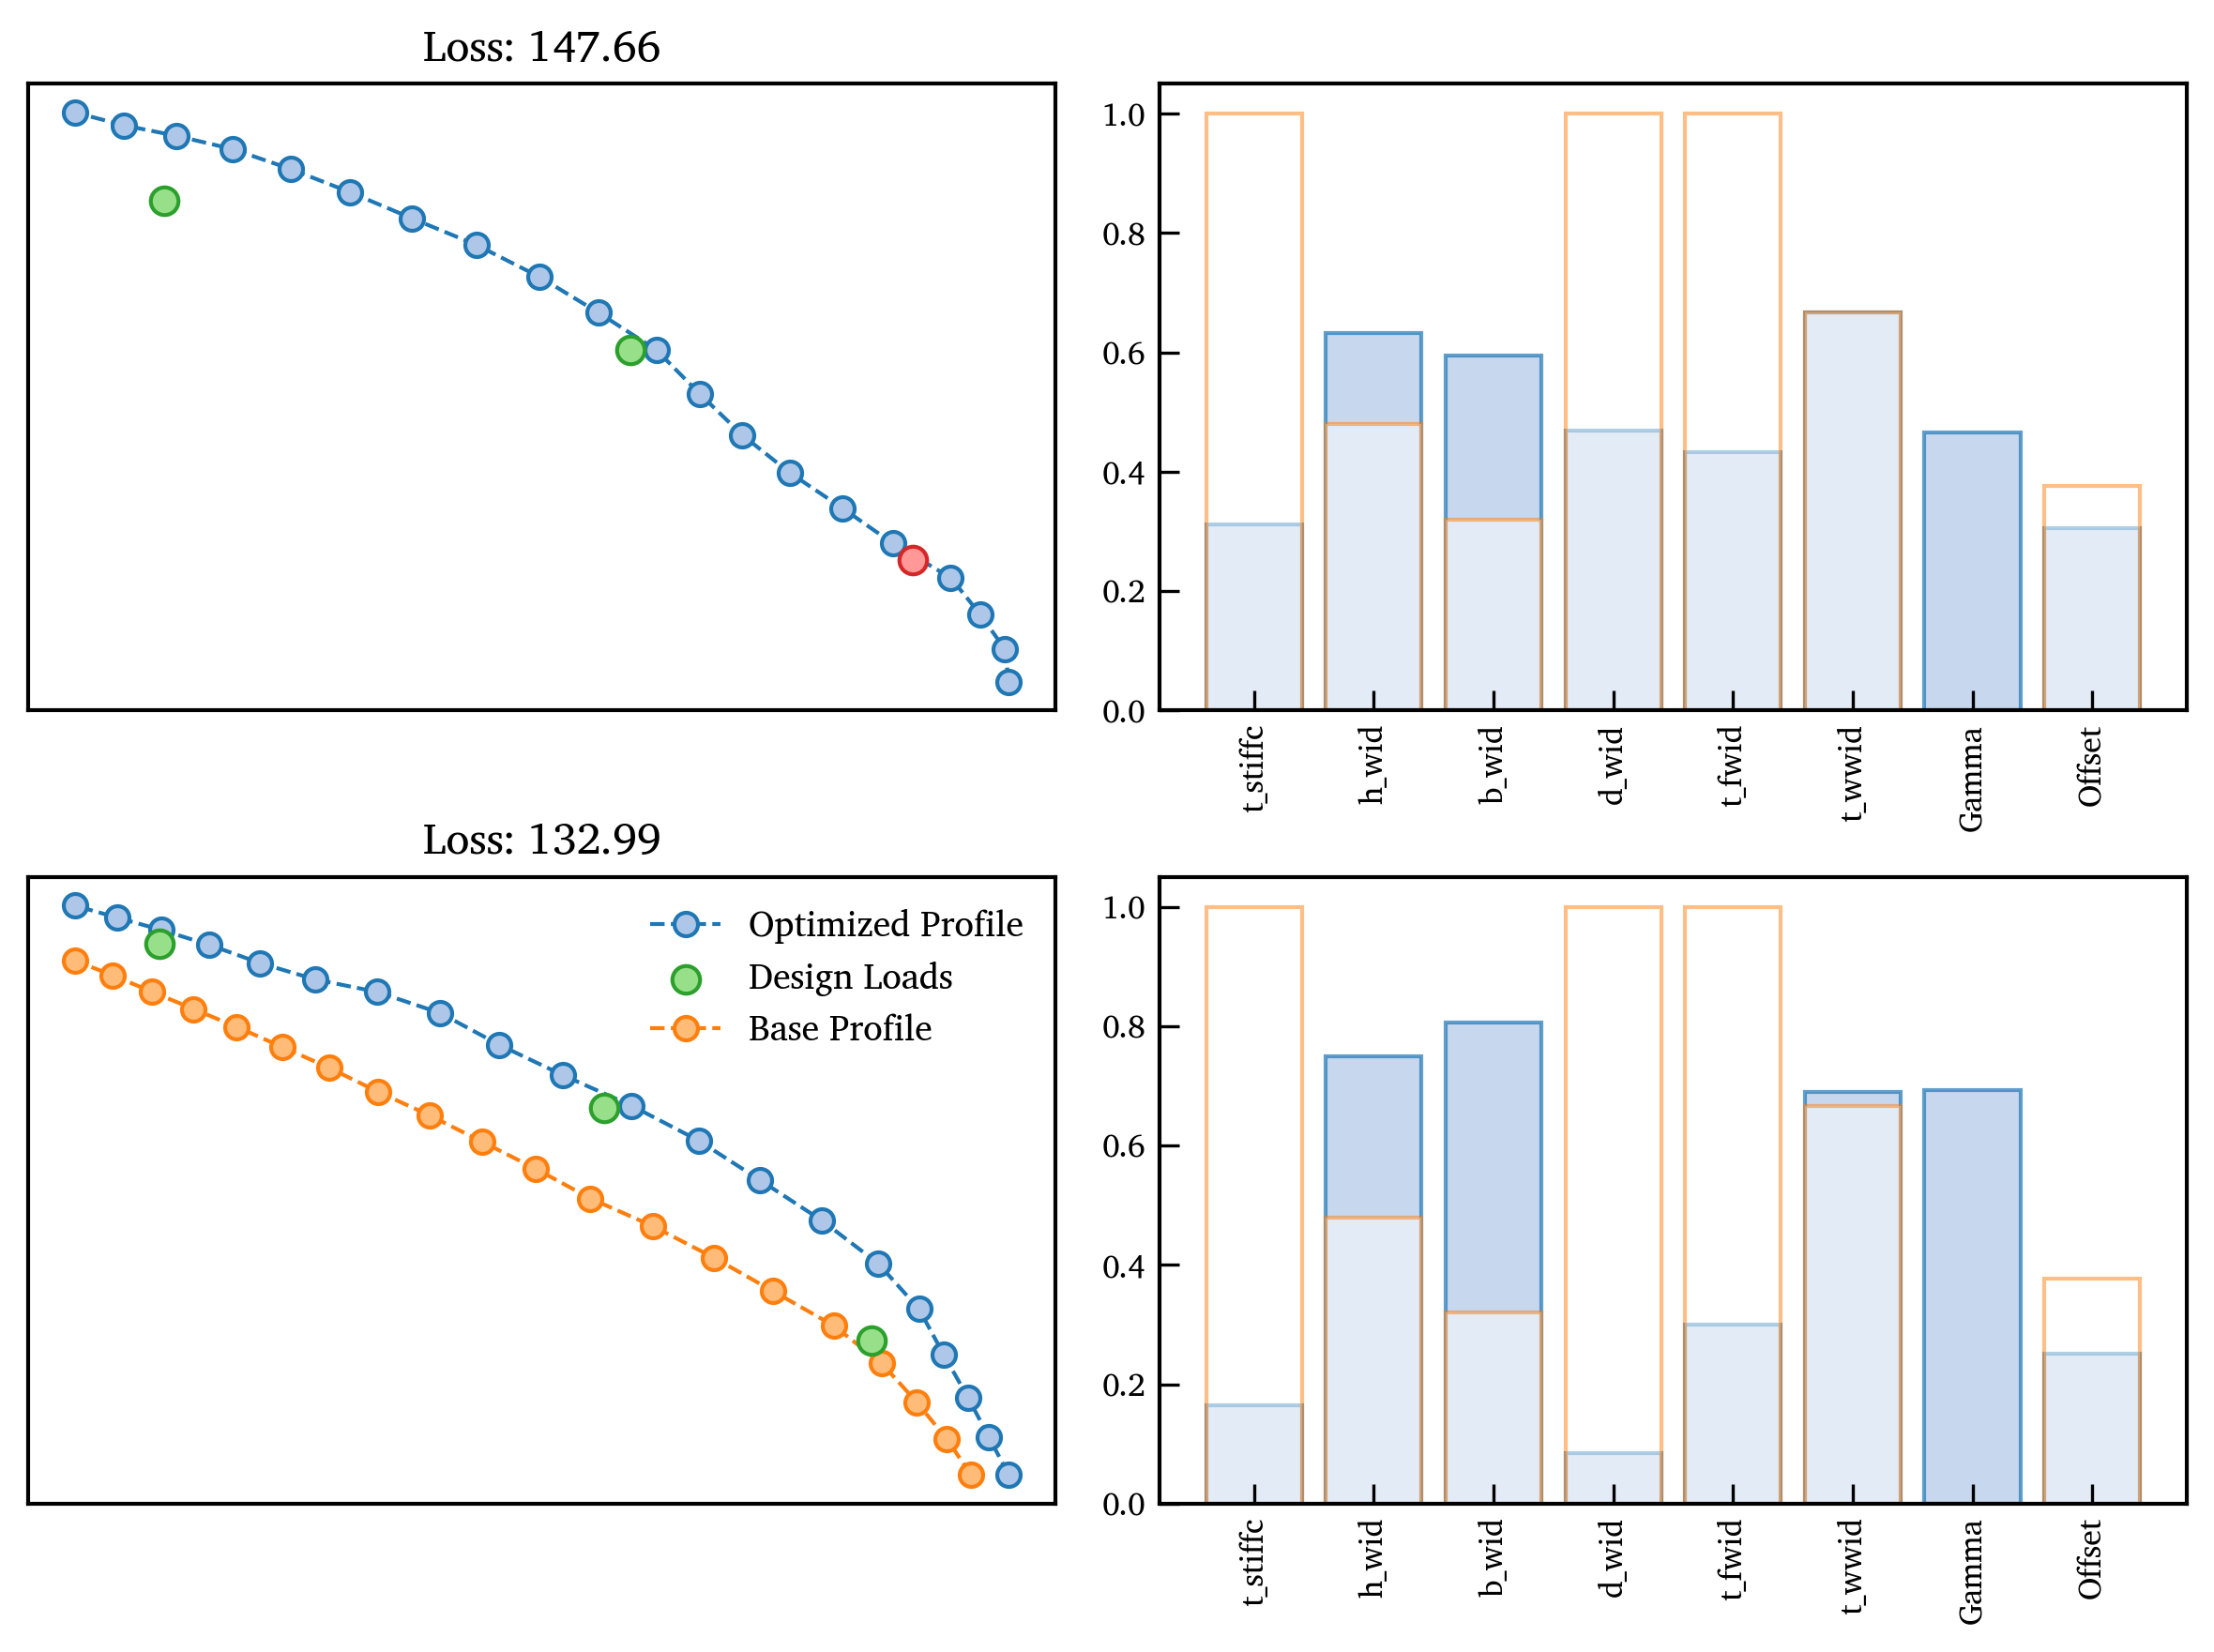

In [123]:
plot_every_n = 1
iterations = len(optimization_history)
counter = 0
n_plots = iterations // plot_every_n

upper_bounds = np.array(bounds)[:,1]
lower_bounds = np.array(bounds)[:,0]

fig, axs = plt.subplots(n_plots,2,figsize=(8, 3*n_plots))

for i in range(n_plots):

    step = i * plot_every_n

    params = optimization_history[step]['parameters']
    params_dict = optimization_history[step]['parameter_dict']

    params_normed = (params - lower_bounds) / (upper_bounds - lower_bounds)

    profile_step = base_profile.copy()
    profile_step[design_parameters] = params
    M_Rd_step, V_Rd_step, _ = model_forward.get_MV_interaction_prediction(profile_step,n_predictions=n_predictions)
    interaction_curve_step = np.array([M_Rd_step, V_Rd_step]).T

    if i == n_plots - 1:
        label='Optimized Profile'
    else:
        label=None

    ax = axs[i,0]
    ax.plot(interaction_curve_step[:, 0],
          interaction_curve_step[:, 1],
          marker='o',
          markeredgecolor=plot_params.morecolors[0],
          markerfacecolor=plot_params.morecolors[1],
          linestyle='--',
          linewidth=1,
          zorder=0,
          label=label)
    
    for j, load in enumerate(design_loads):
        if j == 0:
            label='Design Loads'
        else:
            label=None
        colors = [plot_params.morecolors[5],plot_params.morecolors[4]] if not optimization_history[step]['violations'][j] else [plot_params.morecolors[7],plot_params.morecolors[6]]
        ax.scatter(load[0],
                    load[1],
                    s=50,
                    facecolors=colors[0],
                    edgecolors=colors[1],
                    label=label,
                    zorder=3)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Loss: {optimization_history[step]['total_loss']:.2f}")
    
    ax = axs[i,1]
    ax.bar(np.arange(len(params_normed)),
           params_normed,
           color=plot_params.morecolors[1],
           edgecolor=plot_params.morecolors[0],
           alpha=0.7)
    params_base_normed = (base_profile[design_parameters].values.flatten() - lower_bounds) / (upper_bounds - lower_bounds)
    ax.bar(np.arange(len(params_base_normed)),
           params_base_normed,
           facecolor='white',
           edgecolor=plot_params.morecolors[2],
           alpha=0.5)
    
    ax.set_xticks(np.arange(len(params_normed)),list(params_dict.keys()), rotation=90)

ax = axs[-1,0]
ax.plot(interaction_curve_base[:, 0],
          interaction_curve_base[:, 1],
          marker='o',
          markeredgecolor=plot_params.morecolors[2],
          markerfacecolor=plot_params.morecolors[3],
          linestyle='--',
          linewidth=1,
          zorder=0,
          label="Base Profile")


ax.legend()
plt.tight_layout()
plt.show()
